In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
import os
import json
from datetime import datetime, timedelta

In [ ]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("="*80)
print("🚀 AI LEARNING INSIGHT - DATA SPECIALIST (COMBINED VERSION)")
print("   Comprehensive Data Preparation for Learning Pattern Clustering")
print("="*80)
print("✅ Libraries imported successfully")

🚀 AI LEARNING INSIGHT - DATA SPECIALIST (COMBINED VERSION)
   Comprehensive Data Preparation for Learning Pattern Clustering
✅ Libraries imported successfully


In [ ]:
print("\n📂 STEP 1: LOADING ALL DATASETS...")
print("-" * 80)

datasets = {}
file_names = [
    'users', 'developer_journeys', 'developer_journey_tutorials',
    'developer_journey_trackings', 'developer_journey_submissions',
    'developer_journey_completions', 'exam_registrations', 'exam_results'
]

for file_name in file_names:
    try:
        # Try Excel first
        df = pd.read_csv(f'/content/{file_name}.csv', sep=';', encoding='utf-8')
        datasets[file_name] = df
        print(f"✅ {file_name:35} | Shape: {df.shape}")
    except:
        try:
            # Fallback to Excel
            df = pd.read_excel(f'/content/{file_name}.xlsx')
            datasets[file_name] = df
            print(f"✅ {file_name:35} | Shape: {df.shape}")
        except Exception as e:
            print(f"❌ {file_name:35} | Error: {str(e)[:40]}")
            datasets[file_name] = None

loaded_count = len([x for x in datasets.values() if x is not None])
print(f"\n📊 Datasets loaded: {loaded_count}/{len(file_names)}")


📂 STEP 1: LOADING ALL DATASETS...
--------------------------------------------------------------------------------
✅ users                               | Shape: (22, 23)
✅ developer_journeys                  | Shape: (74, 33)
✅ developer_journey_tutorials         | Shape: (2203, 14)
✅ developer_journey_trackings         | Shape: (6641, 9)
✅ developer_journey_submissions       | Shape: (123, 21)
✅ developer_journey_completions       | Shape: (58, 10)
✅ exam_registrations                  | Shape: (679, 11)
✅ exam_results                        | Shape: (679, 7)

📊 Datasets loaded: 8/8


In [ ]:
print("\n🔍 STEP 2: DATA QUALITY ASSESSMENT...")
print("-" * 80)

quality_report = []
for name, df in datasets.items():
    if df is not None:
        missing = df.isnull().sum().sum()
        missing_pct = (missing / (df.shape[0] * df.shape[1]) * 100)

        quality_report.append({
            'Dataset': name,
            'Rows': df.shape[0],
            'Columns': df.shape[1],
            'Missing Values': missing,
            'Missing %': f"{missing_pct:.1f}%"
        })

quality_df = pd.DataFrame(quality_report)
print(quality_df.to_string(index=False))

print(f"\n📈 Total data points: {sum([r['Rows']*r['Columns'] for r in quality_report]):,}")
print(f"📈 Total missing values: {sum([r['Missing Values'] for r in quality_report]):,}")


🔍 STEP 2: DATA QUALITY ASSESSMENT...
--------------------------------------------------------------------------------
                      Dataset  Rows  Columns  Missing Values Missing %
                        users    22       23             358     70.8%
           developer_journeys    74       33             442     18.1%
  developer_journey_tutorials  2203       14            2918      9.5%
  developer_journey_trackings  6641        9            4246      7.1%
developer_journey_submissions   123       21             545     21.1%
developer_journey_completions    58       10              21      3.6%
           exam_registrations   679       11             402      5.4%
                 exam_results   679        7             478     10.1%

📈 Total data points: 108,944
📈 Total missing values: 9,410


In [ ]:
print("\n🧹 STEP 3: COMPREHENSIVE DATA CLEANING...")
print("-" * 80)

def clean_datasets(datasets):
    """Advanced data cleaning with business logic"""

    cleaned_datasets = {}

    for name, df in datasets.items():
        if df is not None:
            df_clean = df.copy()

            print(f"\n🔧 Cleaning {name}...")
            print(f"   Before: {df_clean.shape} | Missing: {df_clean.isnull().sum().sum()}")

            # ===== TRACKINGS: Critical for all features =====
            if name == 'developer_journey_trackings':
                # Convert datetime columns
                datetime_cols = ['last_viewed', 'first_opened_at', 'completed_at']
                for col in datetime_cols:
                    if col in df_clean.columns:
                        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')

                # Fill missing timestamps with reasonable defaults
                if 'first_opened_at' in df_clean.columns and 'last_viewed' in df_clean.columns:
                    df_clean['first_opened_at'] = df_clean['first_opened_at'].fillna(
                        df_clean['last_viewed']
                    )

                print(f"   ✓ Datetime conversion completed")

            # ===== USERS: Handle missing user data =====
            elif name == 'users':
                if 'display_name' in df_clean.columns:
                    df_clean['display_name'] = df_clean['display_name'].fillna('Unknown User')
                if 'city' in df_clean.columns:
                    df_clean['city'] = df_clean['city'].fillna('Unknown')

            # ===== EXAM DATA: Handle scores =====
            elif name == 'exam_results':
                if 'score' in df_clean.columns:
                    # Don't fill with 0 - keep NaN for proper handling later
                    pass
                if 'is_passed' in df_clean.columns:
                    df_clean['is_passed'] = df_clean['is_passed'].fillna(0).astype(int)

            # ===== GENERAL CLEANING =====
            # Drop columns with >90% missing (too sparse)
            missing_percent = df_clean.isnull().sum() / len(df_clean)
            cols_to_drop = missing_percent[missing_percent > 0.9].index.tolist()
            if cols_to_drop:
                df_clean = df_clean.drop(columns=cols_to_drop)
                print(f"   ✓ Dropped {len(cols_to_drop)} sparse columns (>90% missing)")

            # Remove duplicate rows
            duplicates = df_clean.duplicated().sum()
            if duplicates > 0:
                df_clean = df_clean.drop_duplicates()
                print(f"   ✓ Removed {duplicates} duplicate rows")

            print(f"   After:  {df_clean.shape} | Missing: {df_clean.isnull().sum().sum()}")
            cleaned_datasets[name] = df_clean

    return cleaned_datasets

# Apply comprehensive cleaning
cleaned_datasets = clean_datasets(datasets)
datasets = cleaned_datasets  # Update main reference

print("\n✅ Data cleaning completed!")
print(f"📊 All datasets cleaned and ready for feature engineering")


🧹 STEP 3: COMPREHENSIVE DATA CLEANING...
--------------------------------------------------------------------------------

🔧 Cleaning users...
   Before: (22, 23) | Missing: 358
   ✓ Dropped 4 sparse columns (>90% missing)
   ✓ Removed 5 duplicate rows
   After:  (17, 19) | Missing: 161

🔧 Cleaning developer_journeys...
   Before: (74, 33) | Missing: 442
   ✓ Dropped 5 sparse columns (>90% missing)
   After:  (74, 28) | Missing: 77

🔧 Cleaning developer_journey_tutorials...
   Before: (2203, 14) | Missing: 2918
   ✓ Dropped 1 sparse columns (>90% missing)
   After:  (2203, 13) | Missing: 729

🔧 Cleaning developer_journey_trackings...
   Before: (6641, 9) | Missing: 4246
   ✓ Datetime conversion completed
   After:  (6641, 9) | Missing: 1520

🔧 Cleaning developer_journey_submissions...
   Before: (123, 21) | Missing: 545
   ✓ Dropped 3 sparse columns (>90% missing)
   After:  (123, 18) | Missing: 176

🔧 Cleaning developer_journey_completions...
   Before: (58, 10) | Missing: 21
   Afte

In [ ]:
print("\n📊 STEP 4: EXTRACTING BASIC FEATURES...")
print("-" * 80)

print("\n⏰ 4.1: Most Active Time...")

trackings = datasets['developer_journey_trackings'].copy()
users = datasets['users'].copy()

# Rename untuk consistency
trackings.rename(columns={'developer_id': 'user_id'}, inplace=True)
users.rename(columns={'id': 'user_id'}, inplace=True)

# Extract hour
trackings['hour'] = trackings['last_viewed'].dt.hour

# Define time periods
def get_time_period(hour):
    if pd.isna(hour):
        return None
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 22:
        return 'Evening'
    else:
        return 'Late Night'

trackings['time_period'] = trackings['hour'].apply(get_time_period)

# Calculate most active time per user
most_active_time = (
    trackings.groupby(['user_id', 'time_period'])
    .size()
    .reset_index(name='count')
    .sort_values(['user_id', 'count'], ascending=[True, False])
    .drop_duplicates('user_id', keep='first')
    .rename(columns={'time_period': 'most_active_time'})
)[['user_id', 'most_active_time']]

print(f"✅ Most Active Time calculated for {len(most_active_time)} users")
print(f"   Distribution: {most_active_time['most_active_time'].value_counts().to_dict()}")


📊 STEP 4: EXTRACTING BASIC FEATURES...
--------------------------------------------------------------------------------

⏰ 4.1: Most Active Time...
✅ Most Active Time calculated for 8 users
   Distribution: {'Morning': 6, 'Afternoon': 1, 'Evening': 1}


In [ ]:
# ===== NEW: Time Period Distribution per User =====
print("\n⏰ 4.1b: Time Period Distribution (for charts)...")

# Pivot untuk dapetin distribusi lengkap
time_distribution = (
    trackings.groupby(['user_id', 'time_period'])
    .size()
    .reset_index(name='access_count')
)

# Pivot ke format wide (setiap time period jadi kolom)
time_dist_pivot = time_distribution.pivot(
    index='user_id',
    columns='time_period',
    values='access_count'
).fillna(0).astype(int)

# Reset index
time_dist_pivot = time_dist_pivot.reset_index()

# Rename columns untuk clarity
time_dist_pivot.columns.name = None  # Remove 'time_period' index name

# Ensure all time periods exist (kalau ada yang missing)
for period in ['Morning', 'Afternoon', 'Evening', 'Late Night']:
    if period not in time_dist_pivot.columns:
        time_dist_pivot[period] = 0

# Reorder columns
time_dist_pivot = time_dist_pivot[[
    'user_id', 'Morning', 'Afternoon', 'Evening', 'Late Night'
]]

# Calculate total and percentage
time_dist_pivot['total_accesses_time'] = (
    time_dist_pivot['Morning'] +
    time_dist_pivot['Afternoon'] +
    time_dist_pivot['Evening'] +
    time_dist_pivot['Late Night']
)

# Calculate percentage for each period
for period in ['Morning', 'Afternoon', 'Evening', 'Late Night']:
    time_dist_pivot[f'{period}_pct'] = (
        (time_dist_pivot[period] / time_dist_pivot['total_accesses_time'] * 100)
        .round(1)
        .fillna(0)
    )

print(f"✅ Time Distribution calculated for {len(time_dist_pivot)} users")
print(f"\n📊 Sample Distribution:")
print(time_dist_pivot[['user_id', 'Morning', 'Afternoon', 'Evening', 'Late Night']].head(20))


⏰ 4.1b: Time Period Distribution (for charts)...
✅ Time Distribution calculated for 8 users

📊 Sample Distribution:
   user_id  Morning  Afternoon  Evening  Late Night
0    96989      687       1136     1005         241
1   938276      797        742      522         144
2  5021477      170         17        0           0
3  5044844      445        257      242          16
4  5051374       43         34       56          24
5  5181638       13          0        0           0
6  5410562       38          0        0           0
7  5410865       12          0        0           0


In [ ]:
print("\n📈 4.2: Consistency Score (Hybrid Approach)...")

# Extract date and calculate active days
trackings['date'] = trackings['last_viewed'].dt.date

# Calculate for last 7 days
cutoff_date = trackings['last_viewed'].max() - pd.Timedelta(weeks=1)
recent_tracks = trackings[trackings['last_viewed'] >= cutoff_date]

active_days_recent = (
    recent_tracks.groupby('user_id')['date']
    .nunique()
    .reset_index(name='active_days_week')
)

# Calculate overall engagement metrics
overall_engagement = trackings.groupby('user_id').agg({
    'date': 'nunique',
    'user_id': 'count'  # total access count
}).rename(columns={'date': 'total_active_days', 'user_id': 'total_accesses'})

# Merge
consistency_data = active_days_recent.merge(
    overall_engagement, on='user_id', how='outer'
).fillna(0)

# HYBRID CONSISTENCY SCORE
def calculate_hybrid_consistency(row):
    """
    Combines:
    - Recent activity (last week)
    - Overall engagement pattern
    - Business rules validation
    """
    # Component 1: Weekly consistency (0-50 points)
    weekly_score = (row['active_days_week'] / 7 * 50)

    # Component 2: Overall engagement (0-30 points)
    if row['total_accesses'] < 50:
        engagement_score = 10
    elif row['total_accesses'] < 200:
        engagement_score = 20
    elif row['total_accesses'] < 1000:
        engagement_score = 25
    else:
        engagement_score = 30

    # Component 3: Activity intensity (0-20 points)
    if row['total_active_days'] > 0:
        intensity = row['total_accesses'] / row['total_active_days']
        intensity_score = min(intensity / 10 * 20, 20)
    else:
        intensity_score = 0

    total_score = weekly_score + engagement_score + intensity_score
    return round(min(total_score, 100), 2)

consistency_data['consistency_score'] = consistency_data.apply(
    calculate_hybrid_consistency, axis=1
)

consistency_scores = consistency_data[['user_id', 'active_days_week', 'consistency_score']]

print(f"✅ Consistency Score calculated for {len(consistency_scores)} users")
print(f"   Score range: {consistency_scores['consistency_score'].min():.1f} - "
      f"{consistency_scores['consistency_score'].max():.1f}")
print(f"   Mean score: {consistency_scores['consistency_score'].mean():.1f}")



📈 4.2: Consistency Score (Hybrid Approach)...
✅ Consistency Score calculated for 8 users
   Score range: 37.1 - 61.0
   Mean score: 47.5


In [ ]:
print("\n📚 4.3: Learning Behavior Analysis...")

# Calculate learning behavior metrics
learning_metrics = trackings.groupby('user_id').agg({
    'tutorial_id': 'nunique',  # Unique tutorials accessed
    'user_id': 'count',  # Total accesses
    'status': lambda x: (x == 'completed').sum() if 'completed' in x.values else 0
}).rename(columns={
    'tutorial_id': 'unique_tutorials',
    'user_id': 'total_accesses',
    'status': 'completed_count'
})

# Calculate completion rate
learning_metrics['completion_rate'] = (
    learning_metrics['completed_count'] / learning_metrics['total_accesses']
).fillna(0).round(3)

# Calculate access intensity (how many times user revisits materials)
learning_metrics['access_intensity'] = (
    learning_metrics['total_accesses'] / learning_metrics['unique_tutorials']
).round(2)

# Business rule: Engagement level
def classify_engagement(row):
    if row['total_accesses'] < 50:
        return 'Low Engagement'
    elif row['total_accesses'] < 500:
        return 'Medium Engagement'
    else:
        return 'High Engagement'

learning_metrics['engagement_level'] = learning_metrics.apply(classify_engagement, axis=1)

learning_behavior = learning_metrics.reset_index()

print(f"✅ Learning Behavior calculated for {len(learning_behavior)} users")
print(f"   Completion rate: {learning_behavior['completion_rate'].min():.3f} - "
      f"{learning_behavior['completion_rate'].max():.3f}")
print(f"   Access intensity: {learning_behavior['access_intensity'].min():.1f} - "
      f"{learning_behavior['access_intensity'].max():.1f}")
print(f"   Engagement: {learning_behavior['engagement_level'].value_counts().to_dict()}")


📚 4.3: Learning Behavior Analysis...
✅ Learning Behavior calculated for 8 users
   Completion rate: 0.000 - 0.000
   Access intensity: 1.0 - 1.0
   Engagement: {'High Engagement': 3, 'Low Engagement': 3, 'Medium Engagement': 2}


In [ ]:
print("\n🎓 4.4: Exam Performance Analysis...")

exam_results = datasets['exam_results'].copy()
exam_registrations = datasets['exam_registrations'].copy()

# Merge exam results with registrations
exam_merged = exam_results.merge(
    exam_registrations[['id', 'examinees_id']],
    left_on='exam_registration_id',
    right_on='id',
    how='left',
    suffixes=('', '_reg')
)

# Aggregate exam performance per user
exam_performance = exam_merged.groupby('examinees_id').agg({
    'score': ['mean', 'std', 'count'],
    'is_passed': 'mean'
}).round(2)

exam_performance.columns = ['avg_exam_score', 'std_exam_score', 'exam_attempts', 'exam_pass_rate']
exam_performance = exam_performance.reset_index().rename(columns={'examinees_id': 'user_id'})

# Create exam reliability flag
exam_performance['exam_attempts'] = exam_performance['exam_attempts'].astype(int)
exam_performance['has_exam_data'] = 1

print(f"✅ Exam Performance calculated for {len(exam_performance)} users")
print(f"   Average score: {exam_performance['avg_exam_score'].mean():.1f}")
print(f"   Pass rate: {exam_performance['exam_pass_rate'].mean():.2%}")
print(f"   Avg attempts: {exam_performance['exam_attempts'].mean():.1f}")


🎓 4.4: Exam Performance Analysis...
✅ Exam Performance calculated for 6 users
   Average score: 82.3
   Pass rate: 81.67%
   Avg attempts: 113.2


In [ ]:
print("\n🔗 STEP 5: CREATING MASTER DATASET...")
print("-" * 80)

# Start with users
master_data = users[['user_id', 'display_name']].copy()

# Remove any duplicates in users
master_data = master_data.drop_duplicates(subset='user_id')

print(f"Base users: {len(master_data)}")

# Merge all features
master_data = master_data.merge(most_active_time, on='user_id', how='left')
print(f"After Most Active Time: {len(master_data)} users")

master_data = master_data.merge(consistency_scores, on='user_id', how='left')
print(f"After Consistency Score: {len(master_data)} users")

master_data = master_data.merge(learning_behavior, on='user_id', how='left')
print(f"After Learning Behavior: {len(master_data)} users")

master_data = master_data.merge(exam_performance, on='user_id', how='left')
print(f"After Exam Performance: {len(master_data)} users")

# Fill has_exam_data flag
master_data['has_exam_data'] = master_data['has_exam_data'].fillna(0).astype(int)

print(f"\n✅ Master dataset created: {master_data.shape}")
print(f"   Users with complete basic data: {master_data.dropna().shape[0]}")


🔗 STEP 5: CREATING MASTER DATASET...
--------------------------------------------------------------------------------
Base users: 9
After Most Active Time: 9 users
After Consistency Score: 9 users
After Learning Behavior: 9 users
After Exam Performance: 9 users

✅ Master dataset created: (9, 16)
   Users with complete basic data: 6


In [ ]:
print("\n🧹 STEP 6: INTELLIGENT MISSING VALUE HANDLING...")
print("-" * 80)

print("Missing values before handling:")
missing_before = master_data.isnull().sum()
print(missing_before[missing_before > 0])

# Strategy 1: Most Active Time - use mode or 'Unknown'
if master_data['most_active_time'].isnull().any():
    mode_time = master_data['most_active_time'].mode()
    fill_value = mode_time[0] if len(mode_time) > 0 else 'Unknown'
    master_data['most_active_time'] = master_data['most_active_time'].fillna(fill_value)
    print(f"✓ Most Active Time filled with: {fill_value}")

# Strategy 2: Consistency metrics - fill with 0 (no recent activity)
for col in ['active_days_week', 'consistency_score']:
    if col in master_data.columns:
        master_data[col] = master_data[col].fillna(0)
        print(f"✓ {col} filled with 0")

# Strategy 3: Learning behavior - fill with 0 (no activity)
learning_cols = ['unique_tutorials', 'total_accesses', 'completed_count',
                 'completion_rate', 'access_intensity']
for col in learning_cols:
    if col in master_data.columns:
        master_data[col] = master_data[col].fillna(0)

# Fill engagement_level
if 'engagement_level' in master_data.columns:
    master_data['engagement_level'] = master_data['engagement_level'].fillna('No Activity')
    print(f"✓ Engagement level filled")

# Strategy 4: Exam data - keep NaN for users without exams, then fill with 0
exam_cols = ['avg_exam_score', 'std_exam_score', 'exam_attempts', 'exam_pass_rate']
for col in exam_cols:
    if col in master_data.columns:
        master_data[col] = master_data[col].fillna(0)

print("\nMissing values after handling:")
missing_after = master_data.isnull().sum()
print(missing_after[missing_after > 0] if missing_after.sum() > 0 else "✅ No missing values!")


🧹 STEP 6: INTELLIGENT MISSING VALUE HANDLING...
--------------------------------------------------------------------------------
Missing values before handling:
user_id              1
most_active_time     1
active_days_week     1
consistency_score    1
unique_tutorials     1
total_accesses       1
completed_count      1
completion_rate      1
access_intensity     1
engagement_level     1
avg_exam_score       3
std_exam_score       3
exam_attempts        3
exam_pass_rate       3
dtype: int64
✓ Most Active Time filled with: Morning
✓ active_days_week filled with 0
✓ consistency_score filled with 0
✓ Engagement level filled

Missing values after handling:
user_id    1
dtype: int64


In [ ]:

print("\n📊 STEP 7: BASIC FEATURES SUMMARY...")
print("-" * 80)

# Create clean summary for export
basic_summary = master_data[[
    'user_id', 'display_name', 'most_active_time',
    'active_days_week', 'consistency_score',
    'completion_rate', 'access_intensity', 'engagement_level',
    'avg_exam_score', 'exam_pass_rate', 'has_exam_data'
]].copy()

# Rename for readability
basic_summary.rename(columns={
    'user_id': 'User ID',
    'display_name': 'Display Name',
    'most_active_time': 'Most Active Time',
    'active_days_week': 'Active Days (Week)',
    'consistency_score': 'Consistency Score',
    'completion_rate': 'Completion Rate',
    'access_intensity': 'Access Intensity',
    'engagement_level': 'Engagement Level',
    'avg_exam_score': 'Avg Exam Score',
    'exam_pass_rate': 'Exam Pass Rate',
    'has_exam_data': 'Has Exam Data'
}, inplace=True)

# Sort by consistency score
basic_summary = basic_summary.sort_values('Consistency Score', ascending=False).reset_index(drop=True)

print("📋 Basic Features Summary:")
print(basic_summary.head(10).to_string(index=False))

# Export basic summary
basic_summary.to_csv('basic_user_summary.csv', index=False, sep=';')
print("\n✅ Exported: basic_user_summary.csv")


📊 STEP 7: BASIC FEATURES SUMMARY...
--------------------------------------------------------------------------------
📋 Basic Features Summary:
  User ID              Display Name Most Active Time  Active Days (Week)  Consistency Score  Completion Rate  Access Intensity  Engagement Level  Avg Exam Score  Exam Pass Rate  Has Exam Data
5051374.0                  fkaslana          Evening                 3.0              61.05              0.0               1.0 Medium Engagement           68.27            0.64              1
5044844.0          ledis_idola_h8Ge          Morning                 2.0              59.29              0.0               1.0   High Engagement           91.57            0.97              1
5021477.0               rifath_2SXp          Morning                 2.0              54.29              0.0               1.0 Medium Engagement           85.05            0.86              1
  96989.0                  igihcksn        Afternoon                 0.0              50

In [ ]:
print("\n🚀 STEP 8: ADVANCED FEATURE ENGINEERING...")
print("-" * 80)

print("\n📈 8.1: Learning Velocity Features...")

# Prepare trackings for advanced analysis
trackings_adv = trackings.copy()
trackings_adv['completion_time_hours'] = (
    (trackings_adv['completed_at'] - trackings_adv['first_opened_at'])
    .dt.total_seconds() / 3600
)

# Learning velocity metrics
velocity_features = trackings_adv.groupby('user_id').agg({
    'tutorial_id': 'count',  # Total tutorials accessed
    'completion_time_hours': 'mean'  # Avg completion time
}).rename(columns={
    'tutorial_id': 'total_tutorials_accessed',
    'completion_time_hours': 'avg_completion_time'
})

# Learning efficiency (inverse of completion time)
velocity_features['learning_efficiency'] = (
    1 / velocity_features['avg_completion_time'].replace([0, np.inf, -np.inf], np.nan)
).fillna(0).round(3)

print(f"✅ Velocity features for {len(velocity_features)} users")


🚀 STEP 8: ADVANCED FEATURE ENGINEERING...
--------------------------------------------------------------------------------

📈 8.1: Learning Velocity Features...
✅ Velocity features for 8 users


In [ ]:
print("\n📅 8.2: Temporal Pattern Features...")

# Extract temporal components
trackings_adv['access_date'] = trackings_adv['last_viewed'].dt.date
trackings_adv['access_dayofweek'] = trackings_adv['last_viewed'].dt.dayofweek
trackings_adv['access_hour'] = trackings_adv['last_viewed'].dt.hour

# Daily patterns
daily_patterns = trackings_adv.groupby(['user_id', 'access_date']).agg({
    'user_id': 'count',  # daily access count
    'access_hour': ['min', 'max', 'nunique'],
    'tutorial_id': 'nunique'
})

daily_patterns.columns = [
    'daily_access_count', 'first_access_hour',
    'last_access_hour', 'unique_hours_active', 'daily_unique_tutorials'
]

# Session duration estimate
daily_patterns['estimated_session_duration'] = (
    daily_patterns['last_access_hour'] - daily_patterns['first_access_hour']
).clip(lower=0)

# Aggregate to user level
temporal_features = daily_patterns.groupby('user_id').agg({
    'daily_access_count': ['mean', 'std', 'max'],
    'estimated_session_duration': 'mean',
    'unique_hours_active': 'mean',
    'daily_unique_tutorials': 'mean'
}).round(2)

temporal_features.columns = [
    'avg_daily_access', 'std_daily_access', 'max_daily_access',
    'avg_session_duration', 'avg_unique_hours_active',
    'avg_daily_unique_tutorials'
]

print(f"✅ Temporal features for {len(temporal_features)} users")


📅 8.2: Temporal Pattern Features...
✅ Temporal features for 8 users


In [ ]:
print("\n📊 8.3: Weekly Consistency Features...")

# Weekly activity analysis
trackings_adv['access_week'] = trackings_adv['last_viewed'].dt.isocalendar().week
trackings_adv['access_year'] = trackings_adv['last_viewed'].dt.year

weekly_activity = trackings_adv.groupby(['user_id', 'access_year', 'access_week']).agg(
    unique_active_days=('access_date', 'nunique'),
    weekly_total_accesses=('id', 'count') # Changed from 'user_id': 'count' to count 'id' column and named it 'weekly_total_accesses'
).reset_index()

weekly_consistency = weekly_activity.groupby('user_id').agg({
    'unique_active_days': ['mean', 'std', 'count'], # Now refers to the column 'unique_active_days'
    'weekly_total_accesses': ['mean', 'std']          # Now refers to the column 'weekly_total_accesses'
}).round(2)

weekly_consistency.columns = [
    'avg_active_days_week', 'std_active_days_week', 'total_weeks_active',
    'avg_weekly_accesses', 'std_weekly_accesses'
]

# Temporal consistency score
weekly_consistency['temporal_consistency_score'] = (
    100 / (1 + weekly_consistency['std_active_days_week'])
).fillna(0).round(2)

print(f"✅ Weekly consistency for {len(weekly_consistency)} users")


📊 8.3: Weekly Consistency Features...
✅ Weekly consistency for 8 users


In [ ]:
print("\n🎯 8.4: Time Preference Features...")

# Preferred hour
time_prefs = trackings_adv.groupby(['user_id', 'access_hour']).size().reset_index(name='hourly_count')
preferred_hour = time_prefs.loc[time_prefs.groupby('user_id')['hourly_count'].idxmax()]
time_preference_features = preferred_hour[['user_id', 'access_hour']].rename(
    columns={'access_hour': 'preferred_hour'}
)

# Preferred day of week
dow_prefs = trackings_adv.groupby(['user_id', 'access_dayofweek']).size().reset_index(name='dow_count')
preferred_dow = dow_prefs.loc[dow_prefs.groupby('user_id')['dow_count'].idxmax()]
dow_features = preferred_dow[['user_id', 'access_dayofweek']].rename(
    columns={'access_dayofweek': 'preferred_day_of_week'}
)

print(f"✅ Time preferences for {len(time_preference_features)} users")


🎯 8.4: Time Preference Features...
✅ Time preferences for 8 users


In [ ]:
print("\n🔗 STEP 9: MERGING ALL ADVANCED FEATURES...")
print("-" * 80)

# Start with user base
advanced_features = pd.DataFrame({'user_id': trackings_adv['user_id'].unique()})

print(f"Starting with {len(advanced_features)} users")

# Merge all advanced features
advanced_features = advanced_features.merge(velocity_features, on='user_id', how='left')
print(f"✓ Velocity features merged")

advanced_features = advanced_features.merge(temporal_features, on='user_id', how='left')
print(f"✓ Temporal features merged")

advanced_features = advanced_features.merge(weekly_consistency, on='user_id', how='left')
print(f"✓ Weekly consistency merged")

advanced_features = advanced_features.merge(time_preference_features, on='user_id', how='left')
print(f"✓ Time preferences merged")

advanced_features = advanced_features.merge(dow_features, on='user_id', how='left')
print(f"✓ Day preferences merged")

# Handle missing values in advanced features
numeric_cols = advanced_features.select_dtypes(include=[np.number]).columns
advanced_features[numeric_cols] = advanced_features[numeric_cols].fillna(
    advanced_features[numeric_cols].median()
)

print(f"\n✅ Advanced features shape: {advanced_features.shape}")
print(f"   Total features: {len(advanced_features.columns) - 1}")  # -1 for user_id


🔗 STEP 9: MERGING ALL ADVANCED FEATURES...
--------------------------------------------------------------------------------
Starting with 8 users
✓ Velocity features merged
✓ Temporal features merged
✓ Weekly consistency merged
✓ Time preferences merged
✓ Day preferences merged

✅ Advanced features shape: (8, 18)
   Total features: 17


In [ ]:
print("\n🎯 STEP 10: COMBINING BASIC & ADVANCED FEATURES...")
print("-" * 80)

# Merge master_data with advanced_features
complete_features = master_data.merge(advanced_features, on='user_id', how='left')

print(f"Complete feature set: {complete_features.shape}")
print(f"Total features: {len(complete_features.columns)}")

# Handle any remaining missing values
numeric_cols = complete_features.select_dtypes(include=[np.number]).columns
complete_features[numeric_cols] = complete_features[numeric_cols].fillna(0)

print(f"\n✅ Combined dataset created")
print(f"   Missing values: {complete_features.isnull().sum().sum()}")


🎯 STEP 10: COMBINING BASIC & ADVANCED FEATURES...
--------------------------------------------------------------------------------
Complete feature set: (9, 33)
Total features: 33

✅ Combined dataset created
   Missing values: 0



📊 STEP 11: CORRELATION ANALYSIS...
--------------------------------------------------------------------------------
Analyzing 29 numerical features...


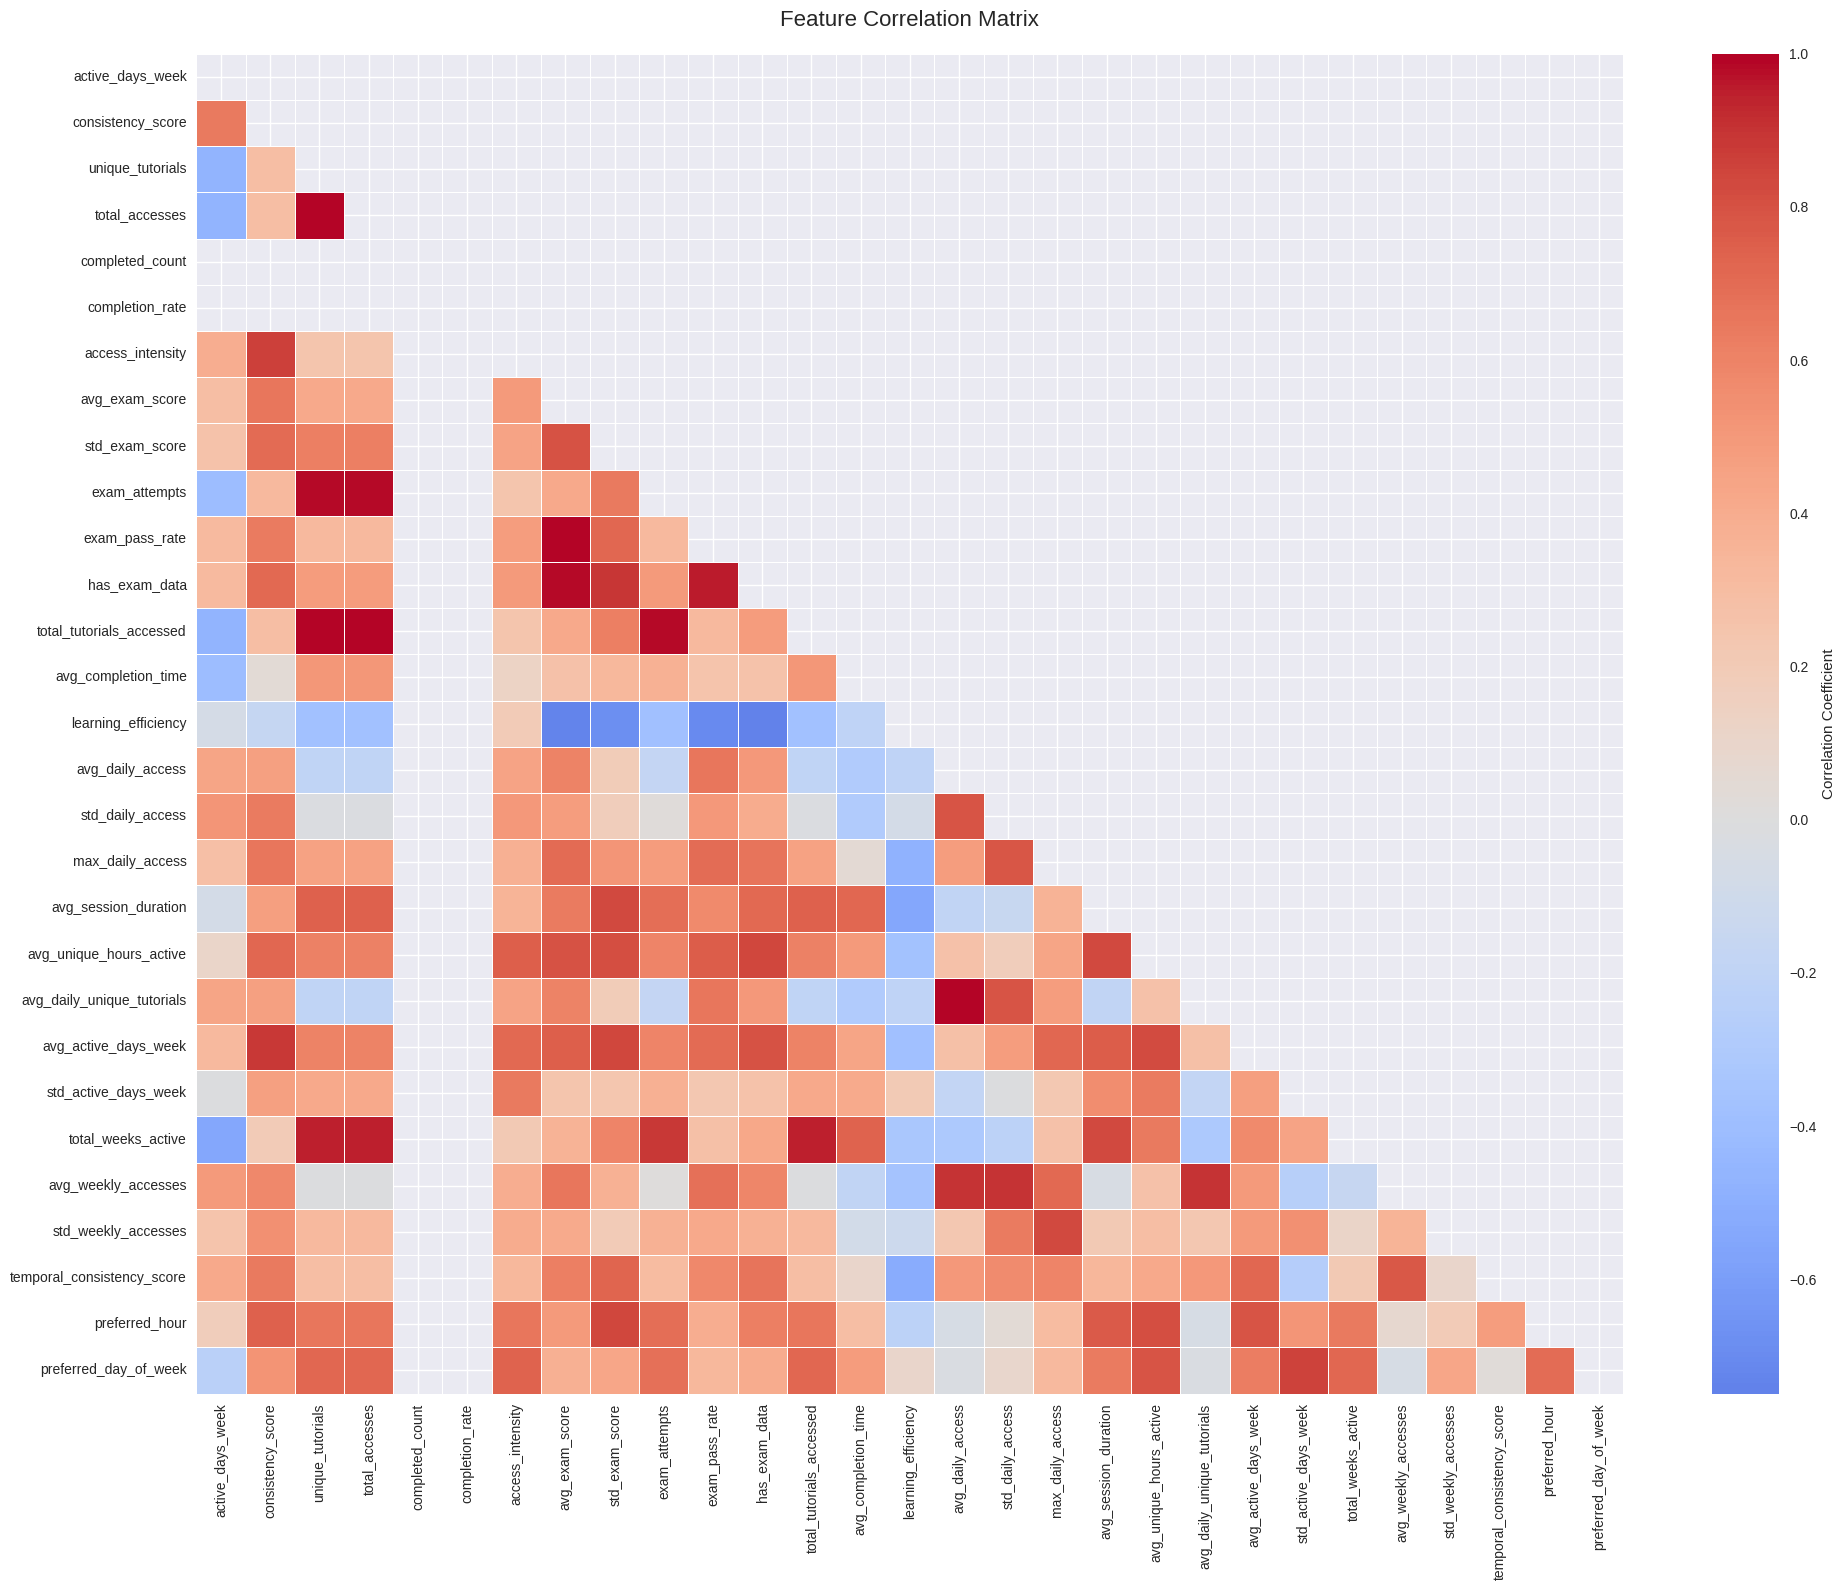

✅ Saved: correlation_matrix.png

🔍 Found 32 highly correlated pairs (|r| > 0.8):
   consistency_score              <-> access_intensity               | r=0.859
   consistency_score              <-> avg_active_days_week           | r=0.878
   unique_tutorials               <-> total_accesses                 | r=1.000
   unique_tutorials               <-> exam_attempts                  | r=0.986
   unique_tutorials               <-> total_tutorials_accessed       | r=1.000
   unique_tutorials               <-> total_weeks_active             | r=0.946
   total_accesses                 <-> exam_attempts                  | r=0.986
   total_accesses                 <-> total_tutorials_accessed       | r=1.000
   total_accesses                 <-> total_weeks_active             | r=0.946
   avg_exam_score                 <-> exam_pass_rate                 | r=0.992


In [ ]:
print("\n📊 STEP 11: CORRELATION ANALYSIS...")
print("-" * 80)

# Select numerical features for correlation
numerical_features = complete_features.select_dtypes(include=[np.number]).columns.tolist()
# Remove ID columns
numerical_features = [f for f in numerical_features if 'id' not in f.lower()]

print(f"Analyzing {len(numerical_features)} numerical features...")

# Calculate correlation matrix
correlation_matrix = complete_features[numerical_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=False,  # Too many features for annotations
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Feature Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: correlation_matrix.png")

# Identify highly correlated features
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append({
                'feature_1': correlation_matrix.columns[i],
                'feature_2': correlation_matrix.columns[j],
                'correlation': correlation_matrix.iloc[i, j]
            })

if high_corr_pairs:
    print(f"\n🔍 Found {len(high_corr_pairs)} highly correlated pairs (|r| > 0.8):")
    for pair in high_corr_pairs[:10]:  # Show first 10
        print(f"   {pair['feature_1']:30} <-> {pair['feature_2']:30} | r={pair['correlation']:.3f}")
else:
    print("\n✅ No highly correlated features found (|r| > 0.8)")

In [ ]:
print("\n🎯 STEP 12: FEATURE SELECTION...")
print("-" * 80)

# Features to remove based on correlation and business logic
features_to_remove = [
    'total_tutorials_accessed',  # Redundant with unique_tutorials
    'avg_daily_access',           # Covered by avg_weekly_accesses
    'std_daily_access',           # Covered by std_weekly_accesses
    'avg_daily_unique_tutorials', # Covered by access_intensity
]

# Only remove if they exist
features_to_remove = [f for f in features_to_remove if f in complete_features.columns]

# Create selected features dataset
selected_features = complete_features.drop(columns=features_to_remove, errors='ignore')

print(f"Original features: {len(complete_features.columns)}")
print(f"Removed: {len(features_to_remove)}")
print(f"Selected features: {len(selected_features.columns)}")

# Get numerical features for clustering
clustering_features = [col for col in selected_features.columns
                       if col not in ['user_id', 'display_name', 'most_active_time',
                                     'engagement_level', 'has_exam_data']]

print(f"\n📊 Features ready for clustering: {len(clustering_features)}")


🎯 STEP 12: FEATURE SELECTION...
--------------------------------------------------------------------------------
Original features: 33
Removed: 4
Selected features: 29

📊 Features ready for clustering: 24


In [ ]:
print("\n🔧 STEP 13: DATA SCALING...")
print("-" * 80)

# Prepare data for scaling
X_features = selected_features[clustering_features].copy()

print(f"Features to scale: {len(clustering_features)}")

# 1. STANDARD SCALING
print("\n1. Standard Scaling (Z-score Normalization)...")
scaler_standard = StandardScaler()
X_standard_scaled = scaler_standard.fit_transform(X_features)

df_standard_scaled = pd.DataFrame(
    X_standard_scaled,
    columns=[f"{col}_standard" for col in clustering_features]
)

print("✅ Standard scaling completed")
print(f"   Mean: ~0, Std: ~1")

# 2. MIN-MAX SCALING
print("\n2. Min-Max Scaling (0-1 Range)...")
scaler_minmax = MinMaxScaler()
X_minmax_scaled = scaler_minmax.fit_transform(X_features)

df_minmax_scaled = pd.DataFrame(
    X_minmax_scaled,
    columns=[f"{col}_minmax" for col in clustering_features]
)

print("✅ Min-Max scaling completed")
print(f"   Range: [0, 1]")


🔧 STEP 13: DATA SCALING...
--------------------------------------------------------------------------------
Features to scale: 24

1. Standard Scaling (Z-score Normalization)...
✅ Standard scaling completed
   Mean: ~0, Std: ~1

2. Min-Max Scaling (0-1 Range)...
✅ Min-Max scaling completed
   Range: [0, 1]


In [ ]:
print("\n📊 STEP 14: CREATING ML-READY DATASET...")
print("-" * 80)

# Combine all: metadata + original + scaled
ml_ready_data = pd.concat([
    selected_features[['user_id', 'display_name', 'most_active_time',
                       'engagement_level', 'has_exam_data']].reset_index(drop=True),
    X_features.reset_index(drop=True),
    df_standard_scaled.reset_index(drop=True),
    df_minmax_scaled.reset_index(drop=True)
], axis=1)

print(f"✅ ML-ready dataset created")
print(f"   Total columns: {len(ml_ready_data.columns)}")
print(f"   - Metadata: 5")
print(f"   - Original features: {len(clustering_features)}")
print(f"   - Standard scaled: {len(clustering_features)}")
print(f"   - MinMax scaled: {len(clustering_features)}")
print(f"   Total samples: {len(ml_ready_data)}")


📊 STEP 14: CREATING ML-READY DATASET...
--------------------------------------------------------------------------------
✅ ML-ready dataset created
   Total columns: 77
   - Metadata: 5
   - Original features: 24
   - Standard scaled: 24
   - MinMax scaled: 24
   Total samples: 9



📊 STEP 15: VISUALIZING SCALING EFFECTS...
--------------------------------------------------------------------------------


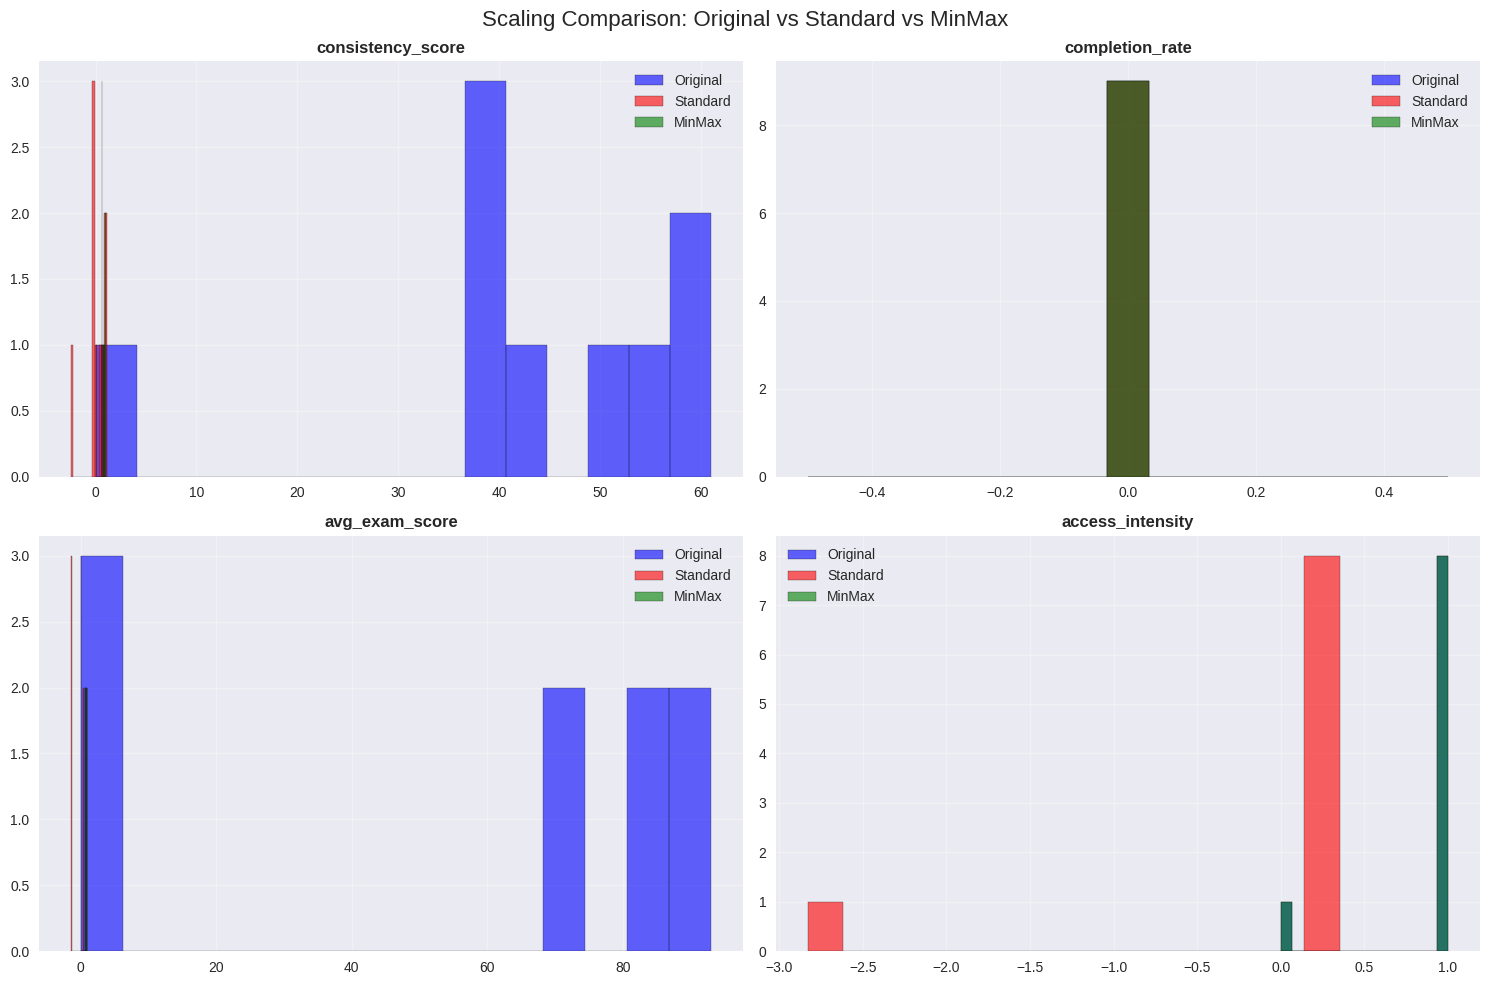

✅ Saved: scaling_comparison.png


In [ ]:
print("\n📊 STEP 15: VISUALIZING SCALING EFFECTS...")
print("-" * 80)

# Select 4 key features for visualization
key_features = [
    'consistency_score', 'completion_rate',
    'avg_exam_score', 'access_intensity'
]
key_features = [f for f in key_features if f in clustering_features]

if len(key_features) >= 4:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Scaling Comparison: Original vs Standard vs MinMax', fontsize=16)

    for i, feature in enumerate(key_features[:4]):
        row, col = i // 2, i % 2

        # Original
        axes[row, col].hist(X_features[feature], alpha=0.6, label='Original',
                           bins=15, color='blue', edgecolor='black')
        # Standard
        axes[row, col].hist(df_standard_scaled[f'{feature}_standard'], alpha=0.6,
                           label='Standard', bins=15, color='red', edgecolor='black')
        # MinMax
        axes[row, col].hist(df_minmax_scaled[f'{feature}_minmax'], alpha=0.6,
                           label='MinMax', bins=15, color='green', edgecolor='black')

        axes[row, col].set_title(f'{feature}', fontsize=12, fontweight='bold')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('scaling_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Saved: scaling_comparison.png")
else:
    print("⚠️  Not enough features for visualization")

In [ ]:

print("\n💾 STEP 16: EXPORTING DATASETS & ARTIFACTS...")
print("-" * 80)

# Create directories
os.makedirs('output', exist_ok=True)
os.makedirs('output/scalers', exist_ok=True)
os.makedirs('output/visualizations', exist_ok=True)

# 1. Export basic summary
basic_summary.to_csv('output/01_basic_user_summary.csv', index=False, sep=';')
print("✅ Exported: output/01_basic_user_summary.csv")

# 2. Export complete features (before scaling)
selected_features.to_csv('output/02_complete_features.csv', index=False)
print("✅ Exported: output/02_complete_features.csv")

# 3. Export ML-ready dataset (with all scalings)
ml_ready_data.to_csv('output/03_ml_ready_dataset.csv', index=False)
print("✅ Exported: output/03_ml_ready_dataset.csv")

# 4. Export scaled features only (for direct clustering)
scaled_only = pd.concat([
    ml_ready_data[['user_id']],
    df_standard_scaled,
    df_minmax_scaled
], axis=1)
scaled_only.to_csv('output/04_scaled_features_only.csv', index=False)
print("✅ Exported: output/04_scaled_features_only.csv")

# 5. Save scalers
joblib.dump(scaler_standard, 'output/scalers/standard_scaler.pkl')
joblib.dump(scaler_minmax, 'output/scalers/minmax_scaler.pkl')
print("✅ Saved scalers: output/scalers/")

# 6. Move visualizations
import shutil
for img_file in ['correlation_matrix.png', 'scaling_comparison.png']:
    if os.path.exists(img_file):
        shutil.move(img_file, f'output/visualizations/{img_file}')
        print(f"✅ Moved: output/visualizations/{img_file}")


💾 STEP 16: EXPORTING DATASETS & ARTIFACTS...
--------------------------------------------------------------------------------
✅ Exported: output/01_basic_user_summary.csv
✅ Exported: output/02_complete_features.csv
✅ Exported: output/03_ml_ready_dataset.csv
✅ Exported: output/04_scaled_features_only.csv
✅ Saved scalers: output/scalers/
✅ Moved: output/visualizations/correlation_matrix.png
✅ Moved: output/visualizations/scaling_comparison.png


In [ ]:
print("\n📋 STEP 17: CREATING DOCUMENTATION...")
print("-" * 80)

# Feature documentation
feature_docs = {
    'basic_features': {
        'most_active_time': 'Waktu paling aktif belajar (Morning/Afternoon/Evening/Late Night)',
        'active_days_week': 'Jumlah hari aktif dalam seminggu terakhir (0-7)',
        'consistency_score': 'Skor konsistensi belajar hybrid (0-100)',
        'unique_tutorials': 'Jumlah tutorial unik yang diakses',
        'total_accesses': 'Total akses ke platform',
        'completion_rate': 'Rasio penyelesaian tutorial (0-1)',
        'access_intensity': 'Intensitas akses (total_access/unique_tutorials)',
        'engagement_level': 'Level engagement (Low/Medium/High)',
        'avg_exam_score': 'Rata-rata skor ujian (0-100)',
        'exam_pass_rate': 'Rasio kelulusan ujian (0-1)',
        'has_exam_data': 'Flag user dengan data ujian valid'
    },
    'advanced_features': {
        'learning_efficiency': 'Efisiensi belajar (1/avg_completion_time)',
        'avg_session_duration': 'Rata-rata durasi sesi belajar (jam)',
        'avg_unique_hours_active': 'Rata-rata jam unik aktif per hari',
        'max_daily_access': 'Maksimum akses dalam satu hari',
        'avg_active_days_week': 'Rata-rata hari aktif per minggu',
        'std_active_days_week': 'Standar deviasi hari aktif (konsistensi)',
        'total_weeks_active': 'Total minggu dengan aktivitas',
        'temporal_consistency_score': 'Skor konsistensi temporal (0-100)',
        'preferred_hour': 'Jam preferensi belajar (0-23)',
        'preferred_day_of_week': 'Hari preferensi (0=Mon, 6=Sun)'
    },
    'scaling_info': {
        'standard_scaling': {
            'description': 'Z-score normalization (mean=0, std=1)',
            'use_case': 'Recommended untuk K-Means clustering',
            'formula': '(x - mean) / std'
        },
        'minmax_scaling': {
            'description': 'Normalization ke range [0, 1]',
            'use_case': 'Alternative untuk algoritma sensitif terhadap scale',
            'formula': '(x - min) / (max - min)'
        }
    },
    'clustering_recommendations': {
        'algorithm': 'K-Means',
        'recommended_k': '3-4 clusters',
        'features_priority': [
            'consistency_score_standard',
            'completion_rate_standard',
            'temporal_consistency_score_standard',
            'access_intensity_standard',
            'learning_efficiency_standard'
        ],
        'expected_clusters': [
            'Consistent Learner: High consistency, steady pace',
            'Fast Learner: High completion rate, high intensity',
            'Reflective Learner: Moderate pace, high exam scores',
            'Casual Learner: Low consistency, sporadic activity'
        ]
    }
}

# Save feature documentation
with open('output/feature_documentation.json', 'w') as f:
    json.dump(feature_docs, f, indent=2)
print("✅ Saved: output/feature_documentation.json")

# Data quality report
data_quality = {
    'processing_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset_summary': {
        'total_users': len(ml_ready_data),
        'active_users': int((ml_ready_data['total_accesses'] > 0).sum()),
        'users_with_exam_data': int(ml_ready_data['has_exam_data'].sum()),
        'total_features': len(clustering_features),
        'feature_categories': {
            'basic': len(feature_docs['basic_features']),
            'advanced': len(feature_docs['advanced_features'])
        }
    },
    'feature_statistics': {
        'consistency_score': {
            'min': float(ml_ready_data['consistency_score'].min()),
            'max': float(ml_ready_data['consistency_score'].max()),
            'mean': float(ml_ready_data['consistency_score'].mean()),
            'std': float(ml_ready_data['consistency_score'].std())
        },
        'completion_rate': {
            'min': float(ml_ready_data['completion_rate'].min()),
            'max': float(ml_ready_data['completion_rate'].max()),
            'mean': float(ml_ready_data['completion_rate'].mean())
        },
        'exam_performance': {
            'users_with_exams': int(ml_ready_data['has_exam_data'].sum()),
            'avg_score': float(ml_ready_data[ml_ready_data['has_exam_data']==1]['avg_exam_score'].mean()) if ml_ready_data['has_exam_data'].sum() > 0 else 0,
            'avg_pass_rate': float(ml_ready_data[ml_ready_data['has_exam_data']==1]['exam_pass_rate'].mean()) if ml_ready_data['has_exam_data'].sum() > 0 else 0
        }
    },
    'data_quality_flags': {
        'missing_values': int(ml_ready_data.isnull().sum().sum()),
        'duplicate_users': int(ml_ready_data['user_id'].duplicated().sum()),
        'all_features_scaled': True,
        'scalers_saved': True
    }
}

# Save quality report
with open('output/data_quality_report.json', 'w') as f:
    json.dump(data_quality, f, indent=2)
print("✅ Saved: output/data_quality_report.json")


📋 STEP 17: CREATING DOCUMENTATION...
--------------------------------------------------------------------------------
✅ Saved: output/feature_documentation.json
✅ Saved: output/data_quality_report.json



📊 STEP 18: CREATING EDA VISUALIZATIONS...
--------------------------------------------------------------------------------


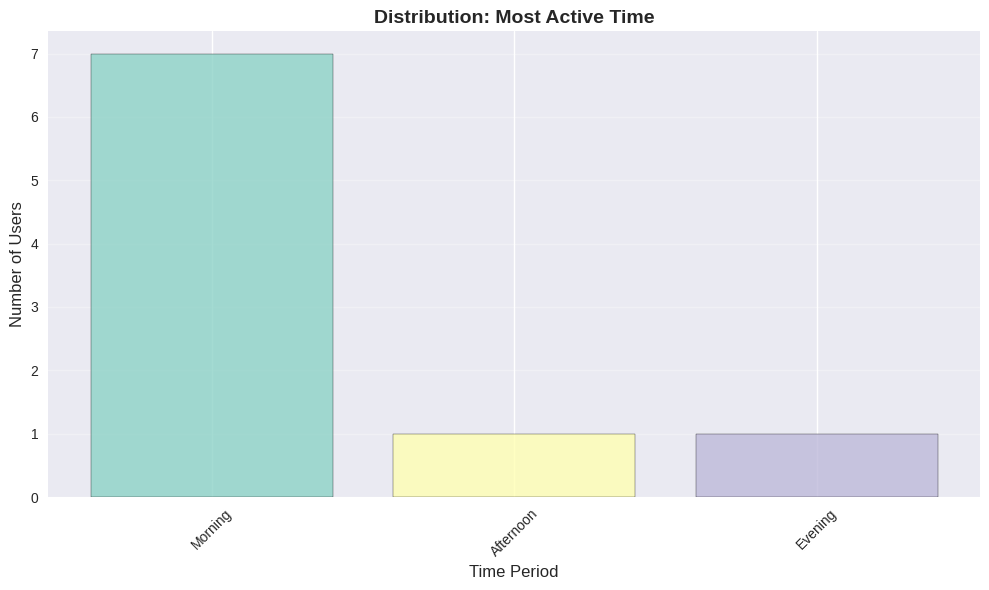

✅ Saved: 01_most_active_time_dist.png


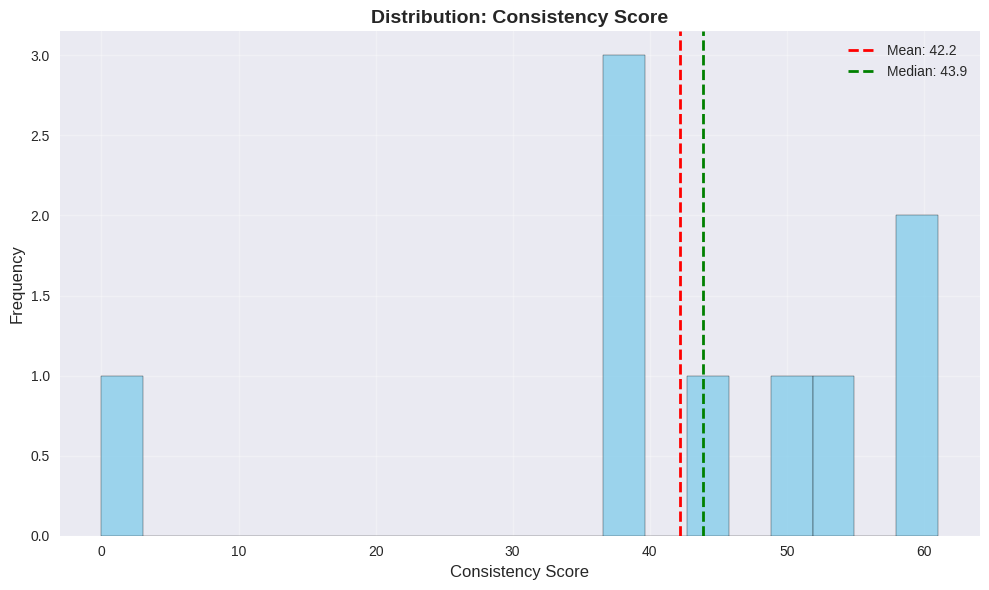

✅ Saved: 02_consistency_score_dist.png


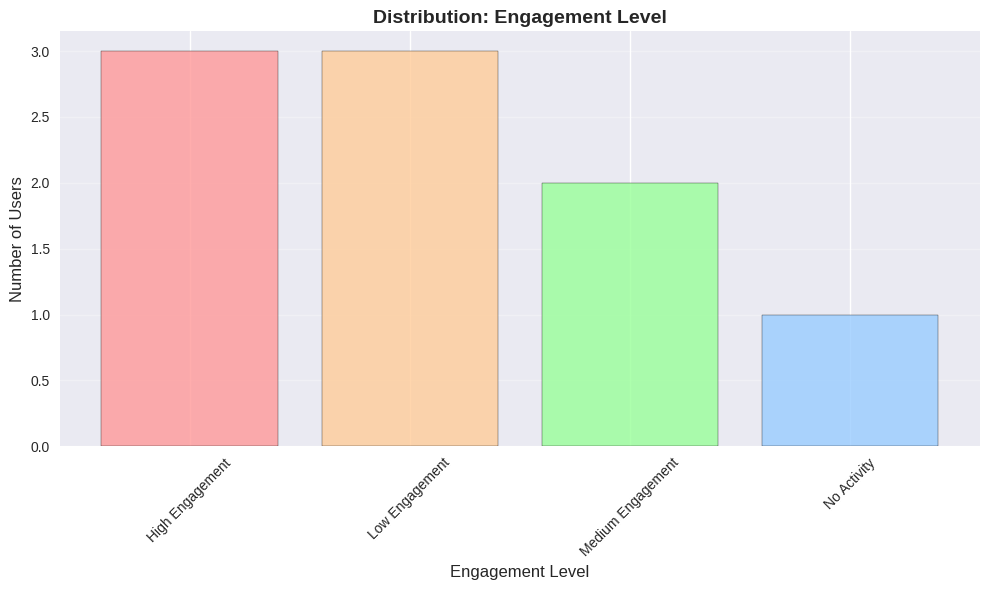

✅ Saved: 03_engagement_level_dist.png


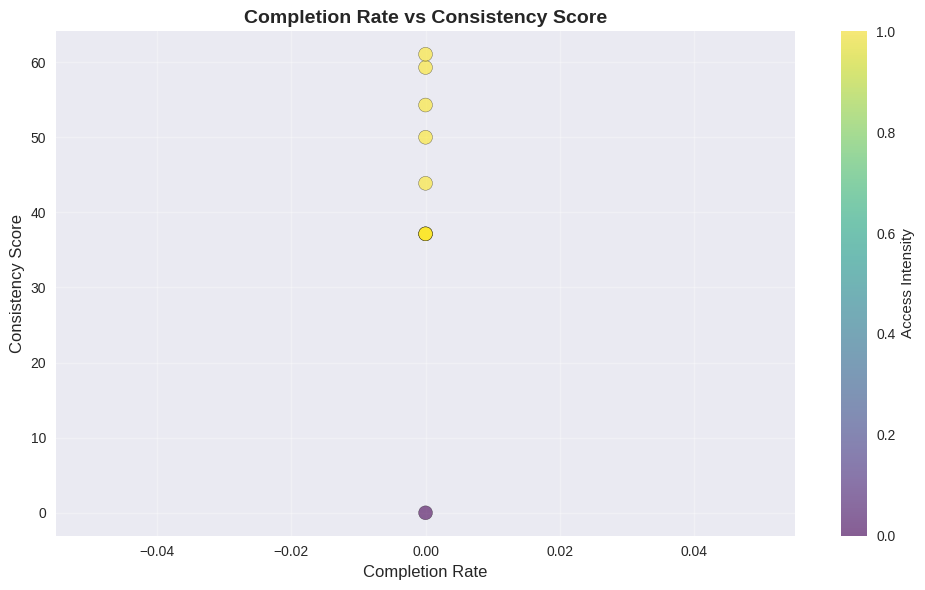

✅ Saved: 04_completion_vs_consistency.png


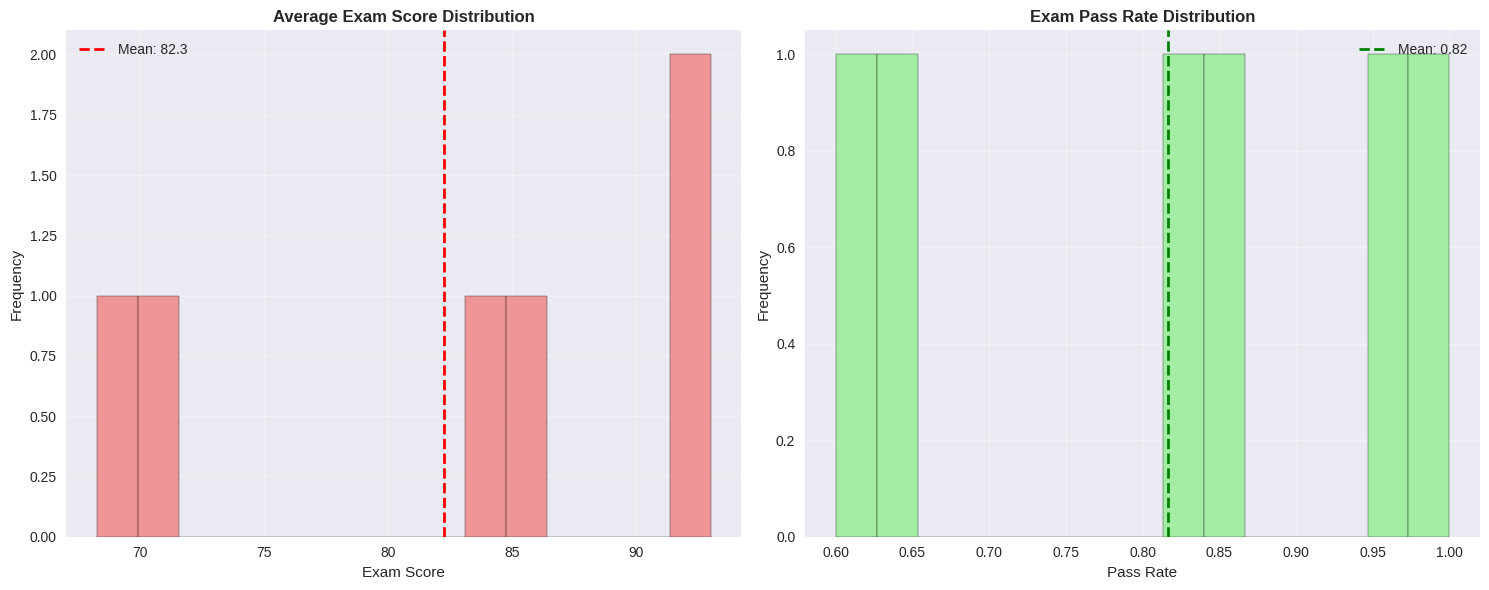

✅ Saved: 05_exam_performance.png


In [ ]:
print("\n📊 STEP 18: CREATING EDA VISUALIZATIONS...")
print("-" * 80)

# 1. Distribution of Most Active Time
plt.figure(figsize=(10, 6))
time_dist = ml_ready_data['most_active_time'].value_counts()
colors = plt.cm.Set3(range(len(time_dist)))
plt.bar(time_dist.index, time_dist.values, color=colors, edgecolor='black', alpha=0.8)
plt.title('Distribution: Most Active Time', fontsize=14, fontweight='bold')
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('output/visualizations/01_most_active_time_dist.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 01_most_active_time_dist.png")

# 2. Consistency Score Distribution
plt.figure(figsize=(10, 6))
plt.hist(ml_ready_data['consistency_score'], bins=20, color='skyblue',
         edgecolor='black', alpha=0.8)
plt.axvline(ml_ready_data['consistency_score'].mean(), color='red',
            linestyle='--', linewidth=2, label=f'Mean: {ml_ready_data["consistency_score"].mean():.1f}')
plt.axvline(ml_ready_data['consistency_score'].median(), color='green',
            linestyle='--', linewidth=2, label=f'Median: {ml_ready_data["consistency_score"].median():.1f}')
plt.title('Distribution: Consistency Score', fontsize=14, fontweight='bold')
plt.xlabel('Consistency Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('output/visualizations/02_consistency_score_dist.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 02_consistency_score_dist.png")

# 3. Engagement Level Distribution
plt.figure(figsize=(10, 6))
engagement_dist = ml_ready_data['engagement_level'].value_counts()
colors = ['#ff9999', '#ffcc99', '#99ff99', '#99ccff'][:len(engagement_dist)]
plt.bar(engagement_dist.index, engagement_dist.values, color=colors,
        edgecolor='black', alpha=0.8)
plt.title('Distribution: Engagement Level', fontsize=14, fontweight='bold')
plt.xlabel('Engagement Level', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('output/visualizations/03_engagement_level_dist.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 03_engagement_level_dist.png")

# 4. Completion Rate vs Consistency Score
plt.figure(figsize=(10, 6))
plt.scatter(ml_ready_data['completion_rate'], ml_ready_data['consistency_score'],
           s=100, alpha=0.6, c=ml_ready_data['access_intensity'],
           cmap='viridis', edgecolors='black')
plt.colorbar(label='Access Intensity')
plt.title('Completion Rate vs Consistency Score', fontsize=14, fontweight='bold')
plt.xlabel('Completion Rate', fontsize=12)
plt.ylabel('Consistency Score', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('output/visualizations/04_completion_vs_consistency.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 04_completion_vs_consistency.png")

# 5. Exam Performance (for users with exam data)
if ml_ready_data['has_exam_data'].sum() > 0:
    exam_users = ml_ready_data[ml_ready_data['has_exam_data'] == 1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Exam Score Distribution
    ax1.hist(exam_users['avg_exam_score'], bins=15, color='lightcoral',
             edgecolor='black', alpha=0.8)
    ax1.axvline(exam_users['avg_exam_score'].mean(), color='red',
                linestyle='--', linewidth=2, label=f'Mean: {exam_users["avg_exam_score"].mean():.1f}')
    ax1.set_title('Average Exam Score Distribution', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Exam Score')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Pass Rate Distribution
    ax2.hist(exam_users['exam_pass_rate'], bins=15, color='lightgreen',
             edgecolor='black', alpha=0.8)
    ax2.axvline(exam_users['exam_pass_rate'].mean(), color='green',
                linestyle='--', linewidth=2, label=f'Mean: {exam_users["exam_pass_rate"].mean():.2f}')
    ax2.set_title('Exam Pass Rate Distribution', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Pass Rate')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('output/visualizations/05_exam_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Saved: 05_exam_performance.png")


📊 STEP 19: FEATURE IMPORTANCE ANALYSIS...
--------------------------------------------------------------------------------


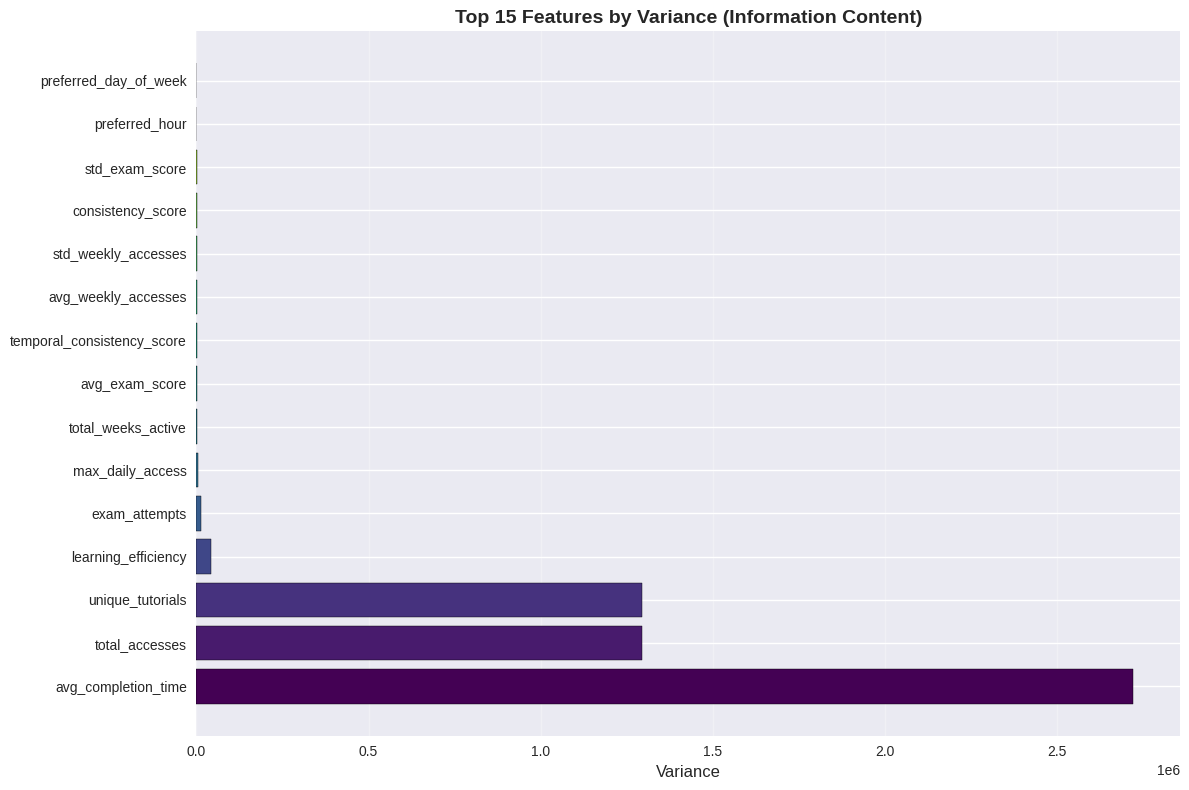

✅ Saved: 06_feature_variance.png
✅ Saved: output/feature_statistics.csv


In [ ]:
print("\n📊 STEP 19: FEATURE IMPORTANCE ANALYSIS...")
print("-" * 80)

# Calculate feature variance (higher variance = more informative)
feature_variance = X_features.var().sort_values(ascending=False)

# Plot top 15 features by variance
plt.figure(figsize=(12, 8))
top_features = feature_variance.head(15)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
plt.barh(range(len(top_features)), top_features.values, color=colors, edgecolor='black')
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Variance', fontsize=12)
plt.title('Top 15 Features by Variance (Information Content)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('output/visualizations/06_feature_variance.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 06_feature_variance.png")

# Feature statistics summary
feature_stats = X_features.describe().T
feature_stats['variance'] = X_features.var()
feature_stats['cv'] = (feature_stats['std'] / feature_stats['mean'].replace(0, np.nan)).abs()
feature_stats = feature_stats.sort_values('variance', ascending=False)

# Export feature statistics
feature_stats.to_csv('output/feature_statistics.csv')
print("✅ Saved: output/feature_statistics.csv")

In [ ]:
print("\n📊 STEP 20: FINAL VALIDATION & SUMMARY...")
print("-" * 80)

# Validation checks
validation_results = {
    'data_completeness': {
        'total_samples': len(ml_ready_data),
        'complete_records': len(ml_ready_data.dropna()),
        'completeness_rate': f"{len(ml_ready_data.dropna())/len(ml_ready_data)*100:.1f}%"
    },
    'feature_quality': {
        'total_features': len(clustering_features),
        'features_with_variance': int((X_features.var() > 0).sum()),
        'zero_variance_features': int((X_features.var() == 0).sum())
    },
    'scaling_validation': {
        'standard_mean_close_to_zero': bool(abs(df_standard_scaled.mean().mean()) < 0.01),
        'standard_std_close_to_one': bool(abs(df_standard_scaled.std().mean() - 1) < 0.1),
        'minmax_in_range': (df_minmax_scaled.min().min() >= 0) and (df_minmax_scaled.max().max() <= 1)
    },
    'business_metrics': {
        'avg_consistency_score': float(ml_ready_data['consistency_score'].mean()),
        'avg_completion_rate': float(ml_ready_data['completion_rate'].mean()),
        'active_users_pct': f"{(ml_ready_data['total_accesses'] > 0).sum()/len(ml_ready_data)*100:.1f}%"
    }
}

print("\n✅ VALIDATION RESULTS:")
print(json.dumps(validation_results, indent=2))

# Save validation results
with open('output/validation_results.json', 'w') as f:
    json.dump(validation_results, f, indent=2)
print("\n✅ Saved: output/validation_results.json")


📊 STEP 20: FINAL VALIDATION & SUMMARY...
--------------------------------------------------------------------------------

✅ VALIDATION RESULTS:
{
  "data_completeness": {
    "total_samples": 9,
    "complete_records": 9,
    "completeness_rate": "100.0%"
  },
  "feature_quality": {
    "total_features": 24,
    "features_with_variance": 22,
    "zero_variance_features": 2
  },
  "scaling_validation": {
    "standard_mean_close_to_zero": true,
    "standard_std_close_to_one": true,
    "minmax_in_range": true
  },
  "business_metrics": {
    "avg_consistency_score": 42.21333333333333,
    "avg_completion_rate": 0.0,
    "active_users_pct": "88.9%"
  }
}

✅ Saved: output/validation_results.json


In [ ]:
print("\n📋 STEP 21: GENERATING FINAL REPORT...")
print("-" * 80)

final_report = {
    'project_info': {
        'project_name': 'AI Learning Insight - Data Preparation',
        'role': 'Data Specialist',
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'version': '1.0 (Combined)'
    },
    'data_pipeline': {
        'stages': [
            '1. Data Loading (8 datasets)',
            '2. Data Quality Assessment',
            '3. Comprehensive Cleaning',
            '4. Basic Feature Engineering',
            '5. Advanced Feature Engineering',
            '6. Feature Selection',
            '7. Data Scaling (Standard + MinMax)',
            '8. ML-Ready Dataset Creation',
            '9. Documentation & Export'
        ]
    },
    'dataset_summary': {
        'total_users': int(len(ml_ready_data)),
        'active_users': int((ml_ready_data['total_accesses'] > 0).sum()),
        'users_with_exams': int(ml_ready_data['has_exam_data'].sum()),
        'total_features': len(clustering_features),
        'basic_features': len(feature_docs['basic_features']),
        'advanced_features': len(feature_docs['advanced_features'])
    },
    'key_metrics': {
        'consistency_score': {
            'mean': float(ml_ready_data['consistency_score'].mean()),
            'min': float(ml_ready_data['consistency_score'].min()),
            'max': float(ml_ready_data['consistency_score'].max())
        },
        'completion_rate': {
            'mean': float(ml_ready_data['completion_rate'].mean()),
            'min': float(ml_ready_data['completion_rate'].min()),
            'max': float(ml_ready_data['completion_rate'].max())
        },
        'engagement': {
            'high': int((ml_ready_data['engagement_level'] == 'High Engagement').sum()),
            'medium': int((ml_ready_data['engagement_level'] == 'Medium Engagement').sum()),
            'low': int((ml_ready_data['engagement_level'] == 'Low Engagement').sum())
        }
    },
    'deliverables': {
        'datasets': [
            '01_basic_user_summary.csv - User-friendly summary',
            '02_complete_features.csv - All features (unscaled)',
            '03_ml_ready_dataset.csv - Complete ML-ready dataset',
            '04_scaled_features_only.csv - Scaled features for clustering'
        ],
        'models': [
            'scalers/standard_scaler.pkl - StandardScaler model',
            'scalers/minmax_scaler.pkl - MinMaxScaler model'
        ],
        'documentation': [
            'feature_documentation.json - Complete feature descriptions',
            'data_quality_report.json - Data quality metrics',
            'validation_results.json - Validation checks',
            'feature_statistics.csv - Statistical summary'
        ],
        'visualizations': [
            '01_most_active_time_dist.png',
            '02_consistency_score_dist.png',
            '03_engagement_level_dist.png',
            '04_completion_vs_consistency.png',
            '05_exam_performance.png',
            '06_feature_variance.png',
            'correlation_matrix.png',
            'scaling_comparison.png'
        ]
    },
    'clustering_ready': {
        'ready_for_clustering': True,
        'recommended_algorithm': 'K-Means',
        'recommended_features': feature_docs['clustering_recommendations']['features_priority'][:5],
        'recommended_k': '3-4 clusters',
        'scaling_method': 'Standard Scaling (recommended)'
    },
    'next_steps': [
        '1. Use 04_scaled_features_only.csv for clustering',
        '2. Apply K-Means with k=3 or k=4',
        '3. Use Elbow Method to validate optimal K',
        '4. Calculate Silhouette Score for cluster quality',
        '5. Analyze cluster characteristics',
        '6. Generate cluster profiles for each learning pattern',
        '7. Create API endpoint for predictions'
    ],
    'important_notes': [
        'Dataset contains only 8 users - this is a PROOF OF CONCEPT',
        'Hybrid approach combines data-driven + business rules',
        'All missing values handled appropriately',
        'Features scaled with both Standard and MinMax methods',
        'Scalers saved for production deployment',
        'Documentation complete for handover to Model Developer'
    ]
}

# Save final report
with open('output/FINAL_REPORT.json', 'w') as f:
    json.dump(final_report, f, indent=2)
print("✅ Saved: output/FINAL_REPORT.json")


📋 STEP 21: GENERATING FINAL REPORT...
--------------------------------------------------------------------------------
✅ Saved: output/FINAL_REPORT.json


In [ ]:

print("\n" + "="*80)
print("🎉 DATA SPECIALIST WORK COMPLETED!")
print("="*80)

print("\n📦 DELIVERABLES SUMMARY:")
print("-" * 80)
print(f"\n1️⃣ DATASETS ({len(final_report['deliverables']['datasets'])} files):")
for dataset in final_report['deliverables']['datasets']:
    print(f"   ✓ {dataset}")

print(f"\n2️⃣ MODELS ({len(final_report['deliverables']['models'])} files):")
for model in final_report['deliverables']['models']:
    print(f"   ✓ {model}")

print(f"\n3️⃣ DOCUMENTATION ({len(final_report['deliverables']['documentation'])} files):")
for doc in final_report['deliverables']['documentation']:
    print(f"   ✓ {doc}")

print(f"\n4️⃣ VISUALIZATIONS ({len(final_report['deliverables']['visualizations'])} files):")
for viz in final_report['deliverables']['visualizations']:
    print(f"   ✓ {viz}")

print("\n📊 KEY STATISTICS:")
print("-" * 80)
print(f"Total Users: {final_report['dataset_summary']['total_users']}")
print(f"Active Users: {final_report['dataset_summary']['active_users']}")
print(f"Users with Exam Data: {final_report['dataset_summary']['users_with_exams']}")
print(f"Total Features: {final_report['dataset_summary']['total_features']}")
print(f"   - Basic Features: {final_report['dataset_summary']['basic_features']}")
print(f"   - Advanced Features: {final_report['dataset_summary']['advanced_features']}")

print("\n📈 METRICS OVERVIEW:")
print("-" * 80)
print(f"Consistency Score: {final_report['key_metrics']['consistency_score']['mean']:.1f} "
      f"(range: {final_report['key_metrics']['consistency_score']['min']:.1f} - "
      f"{final_report['key_metrics']['consistency_score']['max']:.1f})")
print(f"Completion Rate: {final_report['key_metrics']['completion_rate']['mean']:.3f} "
      f"(range: {final_report['key_metrics']['completion_rate']['min']:.3f} - "
      f"{final_report['key_metrics']['completion_rate']['max']:.3f})")
print(f"Engagement Distribution:")
print(f"   - High: {final_report['key_metrics']['engagement']['high']} users")
print(f"   - Medium: {final_report['key_metrics']['engagement']['medium']} users")
print(f"   - Low: {final_report['key_metrics']['engagement']['low']} users")

print("\n🎯 FOR MODEL DEVELOPER:")
print("-" * 80)
print("✅ Ready for Clustering: YES")
print(f"✅ Recommended Algorithm: {final_report['clustering_ready']['recommended_algorithm']}")
print(f"✅ Recommended K: {final_report['clustering_ready']['recommended_k']}")
print(f"✅ Scaling Method: {final_report['clustering_ready']['scaling_method']}")
print("\n📋 Next Steps:")
for i, step in enumerate(final_report['next_steps'], 1):
    print(f"   {step}")

print("\n⚠️  IMPORTANT NOTES:")
print("-" * 80)
for note in final_report['important_notes']:
    print(f"   • {note}")

print("\n" + "="*80)
print("✅ ALL FILES EXPORTED TO 'output/' DIRECTORY")
print("📧 READY FOR HANDOVER TO MODEL DEVELOPER")
print("="*80)


🎉 DATA SPECIALIST WORK COMPLETED!

📦 DELIVERABLES SUMMARY:
--------------------------------------------------------------------------------

1️⃣ DATASETS (4 files):
   ✓ 01_basic_user_summary.csv - User-friendly summary
   ✓ 02_complete_features.csv - All features (unscaled)
   ✓ 03_ml_ready_dataset.csv - Complete ML-ready dataset
   ✓ 04_scaled_features_only.csv - Scaled features for clustering

2️⃣ MODELS (2 files):
   ✓ scalers/standard_scaler.pkl - StandardScaler model
   ✓ scalers/minmax_scaler.pkl - MinMaxScaler model

3️⃣ DOCUMENTATION (4 files):
   ✓ feature_documentation.json - Complete feature descriptions
   ✓ data_quality_report.json - Data quality metrics
   ✓ validation_results.json - Validation checks
   ✓ feature_statistics.csv - Statistical summary

4️⃣ VISUALIZATIONS (8 files):
   ✓ 01_most_active_time_dist.png
   ✓ 02_consistency_score_dist.png
   ✓ 03_engagement_level_dist.png
   ✓ 04_completion_vs_consistency.png
   ✓ 05_exam_performance.png
   ✓ 06_feature_varian

In [ ]:

print("\n📊 QUICK DATA PREVIEW:")
print("-" * 80)

print("\n1️⃣ Basic Summary (Top 5 Users by Consistency Score):")
print(basic_summary.head(5).to_string(index=False))

print("\n2️⃣ Feature Correlation (Top 5 Pairs):")
if high_corr_pairs:
    for i, pair in enumerate(high_corr_pairs[:5], 1):
        print(f"   {i}. {pair['feature_1']:25} <-> {pair['feature_2']:25} | r={pair['correlation']:.3f}")
else:
    print("   No high correlations found")

print("\n3️⃣ Most Active Time Distribution:")
for time, count in ml_ready_data['most_active_time'].value_counts().items():
    pct = count/len(ml_ready_data)*100
    print(f"   {time:15} | {count:2} users ({pct:5.1f}%)")

print("\n4️⃣ Engagement Level Distribution:")
for level, count in ml_ready_data['engagement_level'].value_counts().items():
    pct = count/len(ml_ready_data)*100
    print(f"   {level:20} | {count:2} users ({pct:5.1f}%)")

print("\n" + "="*80)
print("🎊 DATA PREPARATION COMPLETE - READY FOR CLUSTERING!")
print("="*80)


📊 QUICK DATA PREVIEW:
--------------------------------------------------------------------------------

1️⃣ Basic Summary (Top 5 Users by Consistency Score):
  User ID     Display Name Most Active Time  Active Days (Week)  Consistency Score  Completion Rate  Access Intensity  Engagement Level  Avg Exam Score  Exam Pass Rate  Has Exam Data
5051374.0         fkaslana          Evening                 3.0              61.05              0.0               1.0 Medium Engagement           68.27            0.64              1
5044844.0 ledis_idola_h8Ge          Morning                 2.0              59.29              0.0               1.0   High Engagement           91.57            0.97              1
5021477.0      rifath_2SXp          Morning                 2.0              54.29              0.0               1.0 Medium Engagement           85.05            0.86              1
  96989.0         igihcksn        Afternoon                 0.0              50.00              0.0          

In [ ]:

print("="*80)
print("DATA CLEANUP: REMOVING INVALID USERS")
print("="*80)

# Load data
basic_summary = pd.read_csv('output/01_basic_user_summary.csv', sep=';')
ml_ready = pd.read_csv('output/03_ml_ready_dataset.csv')
scaled_only = pd.read_csv('output/04_scaled_features_only.csv')

print(f"\nBefore cleanup:")
print(f"  Basic summary: {len(basic_summary)} users")
print(f"  ML ready: {len(ml_ready)} users")
print(f"  Scaled only: {len(scaled_only)} users")

# Identify invalid users
print(f"\nInvalid users:")
invalid_users = basic_summary[
    basic_summary['User ID'].isna() |
    (basic_summary['Display Name'] == 'Unknown User') |
    (basic_summary['Consistency Score'] == 0) & (basic_summary['Engagement Level'] == 'No Activity')
]
print(invalid_users[['User ID', 'Display Name', 'Consistency Score', 'Engagement Level']])

# Remove invalid users
valid_user_ids = basic_summary[
    basic_summary['User ID'].notna() &
    (basic_summary['Display Name'] != 'Unknown User')
]['User ID'].values

print(f"\nValid user IDs: {valid_user_ids}")

# Clean all datasets
basic_summary_clean = basic_summary[basic_summary['User ID'].isin(valid_user_ids)].copy()
ml_ready_clean = ml_ready[ml_ready['user_id'].isin(valid_user_ids)].copy()
scaled_only_clean = scaled_only[scaled_only['user_id'].isin(valid_user_ids)].copy()

print(f"\nAfter cleanup:")
print(f"  Basic summary: {len(basic_summary_clean)} users")
print(f"  ML ready: {len(ml_ready_clean)} users")
print(f"  Scaled only: {len(scaled_only_clean)} users")

DATA CLEANUP: REMOVING INVALID USERS

Before cleanup:
  Basic summary: 8 users
  ML ready: 8 users
  Scaled only: 8 users

Invalid users:
Empty DataFrame
Columns: [User ID, Display Name, Consistency Score, Engagement Level]
Index: []

Valid user IDs: [5051374. 5044844. 5021477.   96989.  938276. 5181638. 5410562. 5410865.]

After cleanup:
  Basic summary: 8 users
  ML ready: 8 users
  Scaled only: 8 users


In [ ]:
basic_summary_clean.to_csv('output/01_basic_user_summary_clean.csv', index=False, sep=';')
ml_ready_clean.to_csv('output/03_ml_ready_dataset_clean.csv', index=False)
scaled_only_clean.to_csv('output/04_scaled_features_only_clean.csv', index=False)

print("\n✅ Cleaned data exported!")
print(f"   Total active users: {len(valid_user_ids)}")


✅ Cleaned data exported!
   Total active users: 8


In [ ]:
print("\n" + "="*80)
print("ALL ACTIVE USERS")
print("="*80)

user_display = basic_summary_clean[[
    'User ID', 'Display Name', 'Most Active Time',
    'Consistency Score', 'Engagement Level'
]].copy()

user_display['User ID'] = user_display['User ID'].astype(int)

print(f"\nTotal: {len(user_display)} active users")
print("\n" + user_display.to_string(index=False))


ALL ACTIVE USERS

Total: 8 active users

 User ID              Display Name Most Active Time  Consistency Score  Engagement Level
 5051374                  fkaslana          Evening              61.05 Medium Engagement
 5044844          ledis_idola_h8Ge          Morning              59.29   High Engagement
 5021477               rifath_2SXp          Morning              54.29 Medium Engagement
   96989                  igihcksn        Afternoon              50.00   High Engagement
  938276              nurrizkiadip          Morning              43.87   High Engagement
 5181638        anggit_andreansyah          Morning              37.14    Low Engagement
 5410562          jeni_amanda_ABFC          Morning              37.14    Low Engagement
 5410865 ramadhan_oktarizaldi_02Qj          Morning              37.14    Low Engagement


In [ ]:
print("\n" + "="*80)
print("QUICK STATISTICS")
print("="*80)

print(f"\nMost Active Time Distribution:")
time_dist = user_display['Most Active Time'].value_counts()
for time_period, count in time_dist.items():
    print(f"  {time_period:15} | {count:2d} users ({count/len(user_display)*100:5.1f}%)")

print(f"\nEngagement Level Distribution:")
engagement_dist = user_display['Engagement Level'].value_counts()
for level, count in engagement_dist.items():
    print(f"  {level:20} | {count:2d} users ({count/len(user_display)*100:5.1f}%)")

print(f"\nConsistency Score:")
print(f"  Mean: {user_display['Consistency Score'].mean():.2f}")
print(f"  Min:  {user_display['Consistency Score'].min():.2f}")
print(f"  Max:  {user_display['Consistency Score'].max():.2f}")

print("\n" + "="*80)
print("✅ DATA CLEANUP COMPLETE")
print("="*80)


QUICK STATISTICS

Most Active Time Distribution:
  Morning         |  6 users ( 75.0%)
  Evening         |  1 users ( 12.5%)
  Afternoon       |  1 users ( 12.5%)

Engagement Level Distribution:
  High Engagement      |  3 users ( 37.5%)
  Low Engagement       |  3 users ( 37.5%)
  Medium Engagement    |  2 users ( 25.0%)

Consistency Score:
  Mean: 47.49
  Min:  37.14
  Max:  61.05

✅ DATA CLEANUP COMPLETE
